This kernel aims to provide implementations of NLP ML methods for a set of problems of practical value (so hopefully relevant for buisness applications)

I've decided to analyse products (games) at Steam Store (arguably the most popular gaming platform and store), 
mostly because I know the domain quite well, and because Steam Store has good metadata ecosystem for NLP tasks 
(e.g. reviews have 'helpful' score, 'funny' score, number of hours the reviewer played the game)



**The set of theoretial buisness problems includes:**
* -Extracting nuances (strong/weak points of typical/specific products), which is useful for:
    *    --game developers/publishers to better understand the demands of their customers and deliver higher quality, more competent products
    *    --retailers selling Steam keys to optimise their key stocks based on customer demands and product specifics
    *    --individual customers who'd like to know about pros/cons of a certain product relevant for many other customers before buying it
* -Competitor/Similair products, which is useful for:
    *    --retailers recommending games to individual customers with similair hidden features
    *    --game developers/publishers optimizing game development/maintenance (i.e. focusing on more relevant game features/fixes)
* -Extracting information about brand reputation, especially associated with certain buisness descisions or track of competent solutions, which is useful for:
    *    --game developers/publishers optimising their buisness descisions, marketing
    *    --retailers planning stocks/estimating sales for products by certain developers/publishers
    *    --individual customers to better identifying untrustworthy game developers/publishers, or, on the contrary, solidifying trust/loyalty to specific game developers/publishers



**To try to solve the above buisness problems the following set of NLP problems, among others, were considered:**
1.  Feature/aspect-based Sentiment Analysis [for products/companies]
1.  Topic modeling [for latent features of products]
1.  Named Entity Recognition [for comparable products mentioned in specific context]




**Results:**

The available dataset was found to have certain flaws for our problems 
(e.g. features only bestseller games, the amount of reviews included was not representative),
but those flaws were accounted for in some way or another

Prototypes for solutions of problems 1) and 2) were developed somewhat successfully (one can certainly gain some insights from applying them)

Prototype for solution of problem 3) could not be successfully developed in a reasonable timeframe
and having reasonable amount of model generalization, even with use of additional dataset, largely due to
high demands in entity matching.

More details about solution implementation and their results can be found in the comments to specific cells

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import spacy

In [7]:
from google.colab import files

myfile = files.upload()
data = pd.read_csv("steam_reviews.csv")

Saving steam_reviews.csv to steam_reviews.csv


In [8]:
'''
Some basic EDA after which i've abandoned/alterated some of the initial ideas for this project (above is the final version)
'''

"\nSome basic EDA after which i've abandoned/alterated some of the initial ideas for this project (above is the final version)\n"

In [9]:
data.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


In [10]:
data.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [11]:
data['review_length'] = data.apply(lambda row: len(str(row['review'])), axis=1)

data['recommendation_int'] = data['recommendation'] == 'Recommended'
data['recommendation_int'] = data['recommendation_int'].astype(int)

In [12]:
data.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,review_length,recommendation_int
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,195,1
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,4,1
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,171,1
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,2094,1
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1397,1


In [13]:
len(data['title'].unique()), data['title'].unique()

(48, array(['Expansion - Hearts of Iron IV: Man the Guns', 'Dead by Daylight',
        'Wargroove', 'Wallpaper Engine', 'Factorio',
        'Insurgency: Sandstorm', 'Cold Waters', 'Tannenberg',
        'Pathfinder: Kingmaker', 'MONSTER HUNTER: WORLD',
        'Divinity: Original Sin 2 - Definitive Edition',
        'Football Manager 2019', "Garry's Mod", 'Survivor Pass: Vikendi',
        'Moonlighter', 'Terraria', 'GOD EATER 3',
        'Sid Meier’s Civilization® VI', 'Rocket League®',
        'Subnautica: Below Zero', "Tom Clancy's Rainbow Six® Siege",
        'ASTRONEER', 'Sid Meier’s Civilization® VI: Rise and Fall',
        'Kenshi', 'Euro Truck Simulator 2', 'Grand Theft Auto V',
        'RimWorld', 'NBA 2K19', 'RESIDENT EVIL 2 / BIOHAZARD RE:2',
        'Slay the Spire', 'My Time At Portia', 'Foundation', 'Beat Saber',
        "Sid Meier's Civilization® VI: Gathering Storm", 'Stardew Valley',
        'Farming Simulator 19', "PLAYERUNKNOWN'S BATTLEGROUNDS",
        'Overcooked! 2'

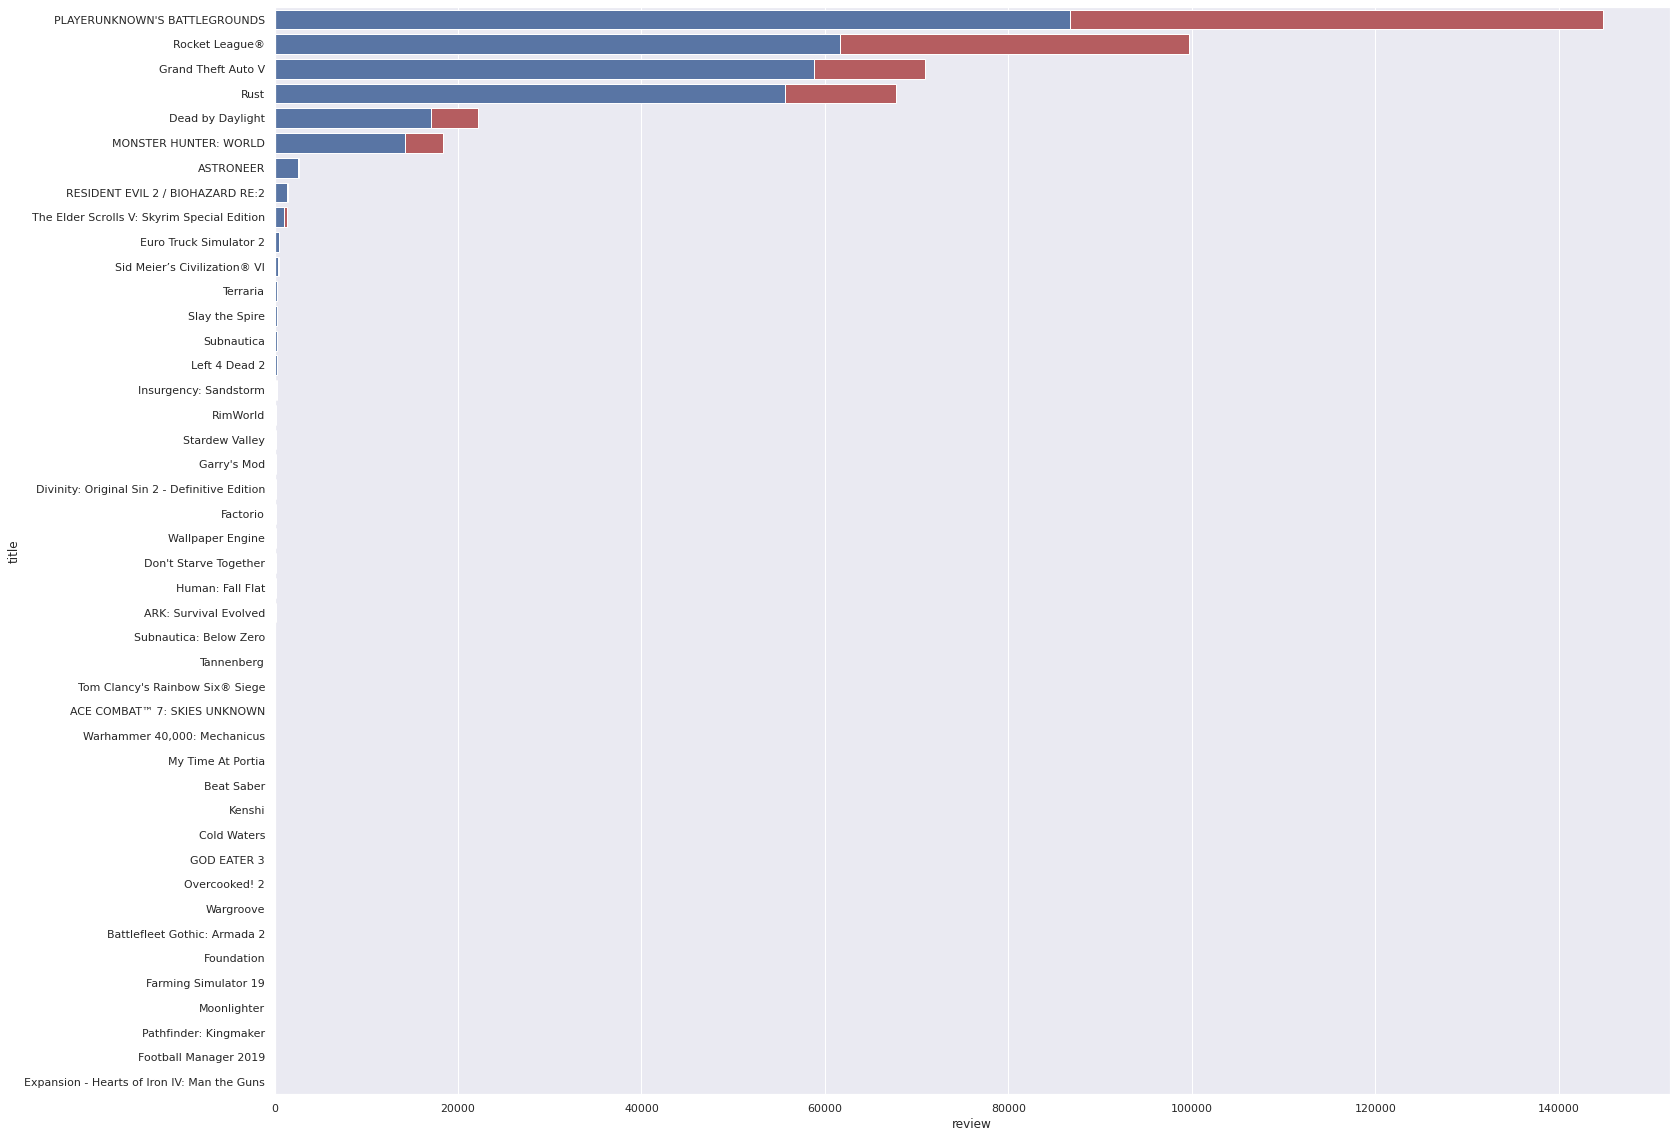

In [14]:
reviews_count = data.groupby(['title'])['review'].count().sort_values(ascending=False)

reviews_count = reviews_count.reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(25,20))
sns.barplot(y=reviews_count['title'], x=reviews_count['review'], data=reviews_count,
            label="Total", color="r")

reviews_count_pos = data.groupby(['title', 'recommendation_int'])['review'].count().sort_values(ascending=False)
reviews_count_pos = reviews_count_pos.reset_index()
reviews_count_pos = reviews_count_pos[reviews_count_pos['recommendation_int'] == 1]
sns.barplot(y=reviews_count_pos['title'], x=reviews_count_pos['review'], data=reviews_count_pos,
            label="Total", color="b")




In [15]:
data.groupby(['title', 'recommendation_int'])['review'].count()
data[data['title'] == "Tom Clancy's Rainbow Six® Siege"]

# R6 Siege in reality has much more reviews and much more mixed score
#=> *pos/neg reviews distribution is completely unrepresentative for some games
#=> *quantity of  reviews distribution is completely unrepresentative for some games


,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,review_length,recommendation_int
110360,2016-11-04,0,0,3671,False,Recommended,Nice Game &lt 3Ich spiele schon seit längerer ...,Tom Clancy's Rainbow Six® Siege,1302,1
110361,2018-05-21,61,1426,6,False,Recommended,Hi there I am a Chinese player. I am writing t...,Tom Clancy's Rainbow Six® Siege,4746,1
110362,2018-01-18,87,1022,113,False,Recommended,Product received for free. This is for the peo...,Tom Clancy's Rainbow Six® Siege,4323,1
110363,2017-06-07,2346,4087,1251,False,Recommended,Buys Starter Edition because cannot afford ful...,Tom Clancy's Rainbow Six® Siege,379,1
110364,2017-06-18,40,1225,200,False,Recommended,Description Tom Clancy's Rainbow Six Siege is ...,Tom Clancy's Rainbow Six® Siege,3751,1
110365,2018-12-22,244,943,42,False,Recommended,Tutorial if you want to buy a diffrent version...,Tom Clancy's Rainbow Six® Siege,336,1
110366,2016-12-14,24,720,2062,False,Recommended,Man I've gone past 1700+ hours now....This gam...,Tom Clancy's Rainbow Six® Siege,7660,1
110367,2018-11-20,30,539,614,False,Recommended,A.) I love this game I have a lot of fun playi...,Tom Clancy's Rainbow Six® Siege,1002,1
110368,2016-06-03,34,631,259,False,Recommended,"EDIT The ""Starter Edition"" mentioned in this r...",Tom Clancy's Rainbow Six® Siege,7881,1
110369,2017-07-26,450,883,461,False,Recommended,With 400 hours of experience with this game I'...,Tom Clancy's Rainbow Six® Siege,142,1


'\n#Just a different take on visualization:\n\npolarity_count_pos = polarity_count[polarity_count[\'recommendation_int\'] == 1]\nsns.barplot(x=polarity_count_pos[\'recommendation_int\'], y=polarity_count_pos[\'review\'], data=polarity_count_pos,\n            label="Total", color="b")\n\npolarity_count_neg = polarity_count[polarity_count[\'recommendation_int\'] == 0]\nsns.barplot(x=polarity_count_neg[\'recommendation_int\'], y=polarity_count_neg[\'review\'], data=polarity_count_neg,\n            label="Total", color="r")\n'

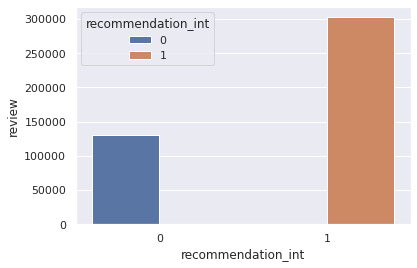

In [16]:
polarity_count = data.groupby(['recommendation_int']).count()
polarity_count = polarity_count.reset_index()


ax = sns.barplot(x=polarity_count['recommendation_int'], y=polarity_count['review'],
            data=polarity_count, hue='recommendation_int')


'''
#Just a different take on visualization:

polarity_count_pos = polarity_count[polarity_count['recommendation_int'] == 1]
sns.barplot(x=polarity_count_pos['recommendation_int'], y=polarity_count_pos['review'], data=polarity_count_pos,
            label="Total", color="b")

polarity_count_neg = polarity_count[polarity_count['recommendation_int'] == 0]
sns.barplot(x=polarity_count_neg['recommendation_int'], y=polarity_count_neg['review'], data=polarity_count_neg,
            label="Total", color="r")
'''

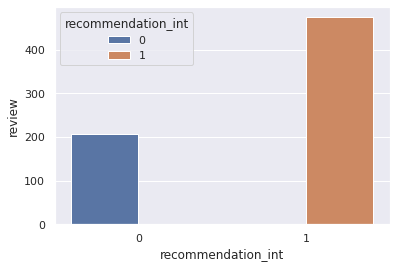

In [17]:
polarity_count = data[data['helpful'] > 50].groupby(['recommendation_int']).count()
polarity_count = polarity_count.reset_index()


ax = sns.barplot(x=polarity_count['recommendation_int'], y=polarity_count['review'],
            data=polarity_count, hue='recommendation_int')


In [18]:
data.isnull().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
review_length                0
recommendation_int           0
dtype: int64

In [19]:
'''
 This cell can be used to prepare reviews data for classifiers
 
 Can take data for all products in general (to analyze typical product reviews)
 Can also take data just for a specific product (e.g. 'Grand Theft Auto V')
'''

clean_data = data.dropna()

#train = clean_data
train = clean_data[clean_data['title'] == 'Grand Theft Auto V']


X = train['review']
y = train['recommendation_int']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=273, stratify=y)

In [20]:
'''
Custom tokenizer for lemmatization from spaCy tokenizer

Used in vectorizers in different tasks here

Prefer using on small datasets, or else processing will take too long
'''

import spacy

# load spacy language model
en_nlp = spacy.load('en', disable=['parser', 'ner'])
spacy_tokenizer = en_nlp.tokenizer

# create a custom tokenizer using the spaCy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

In [21]:
'''
 This cell can be used to build classifiers of positive/negative reviews
 which can be inspected to get insights about why certain reviews are positive/negative
 
 Can be used to analyse what people like/dislike about certain product
 or a selection of products in general
 
 Can possibly be used to label unlabeled comments about the product (like comments on forums)
 
 Deep Learning alternative: LSTM(uni/bi-directional) / 1D-CNN / MLP / their combinations
 can be used, although my limited tests on IMDB dataset(which is quite similair to this Steam Reviews dataset)
 have not found any reasonable justification to use Deep Learning over plain LogisticRegression
 because loss of explainability is obvious, hypothesis space is drasticaly increased, so optimization is harder,
 and, most of all, accuracy gain is negliable (89 LogReg vs 89-90 DL with a lot of tweaking)
'''

from time import time

#from sklearn.naive_bayes import MultinomialNB
#from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Zoo of vectorizers inside a pipline, some include comments
t0 = time()
text_clf = Pipeline([#('vect', CountVectorizer(min_df=5)),
                     #('vect', TfidfTransformer(norm=None)),
                     ('vect', TfidfVectorizer(max_df=0.99, norm='l2')), #< default, cuts some generic words
                     #('vect', TfidfVectorizer(max_df=0.2, norm='l2')), #< default, leaves generic words
                     #('vect', TfidfVectorizer(max_df=0.99, norm='l2', sublinear_tf=True, ngram_range=(2, 2), tokenizer=custom_tokenizer)), #500 sec journey
                     #('vect', TfidfVectorizer(max_df=0.99, norm='l2', sublinear_tf=True, tokenizer=custom_tokenizer)),
                     #('vect', TfidfVectorizer(max_df=0.99, norm='l2', ngram_range=(4, 4))), #< some useful info
                     #('vect', TfidfVectorizer(min_df=5, norm='l2', tokenizer=custom_tokenizer)),
                     #('vect', TfidfVectorizer(min_df=5, norm='l2', tokenizer=custom_tokenizer, max_features=10000)),
                     #('clf', MultinomialNB())
                     #('clf', LogisticRegression(solver='saga', fit_intercept=True, class_weight='balanced'))
                     ('clf', LogisticRegression(solver='saga', fit_intercept=True, class_weight='balanced', C=0.1)) #< reasonable
                     #('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=273, max_iter=5, tol=None)) #< SVM, SGD version, sometimes delivers good results
                    ])
print("preprocessing done in %0.3fs." % (time() - t0))


t0 = time()
text_clf.fit(X_train, y_train)
print("fitting done in %0.3fs." % (time() - t0))

t0 = time()
y_pred = text_clf.predict(X_test)
print("predicting done in %0.3fs." % (time() - t0))
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred)) #, target_names=target_names))

preprocessing done in 0.000s.
fitting done in 3.891s.
predicting done in 0.929s.
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12259
           1       0.88      0.87      0.88     17645

    accuracy                           0.86     29904
   macro avg       0.85      0.85      0.85     29904
weighted avg       0.86      0.86      0.86     29904



In [24]:
'''
 This cell can be used to visualize LogisticRegression coefficients attributed to the tokens,
 which should give an idea of what make a review positive/negative, why customers like/dislike the product, etc.
'''

import eli5

eli5.show_weights(text_clf, vec=text_clf.named_steps["vect"], top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+4.710,best
+3.635,good
+3.356,awesome
+3.350,amazing
+3.331,10
+3.313,great
+3.202,love
+3.013,fun
+2.562,nice
+2.470,friends


In [25]:
'''
 This cell can be used to setup data for topic modeling
 
 Designed to prepare a corpus of negative/positive reviews for certain product
 to further extract latent features via topic modeling methods (LDA/NMF) 
 
 Train/test naming and split steps are present for cinsistency
'''

clean_data = data.dropna()

# Example: here we want to find out why customers who left negative reviews for certain product are not satisfied, 
train = clean_data[(clean_data['title'] == 'Grand Theft Auto V') & (clean_data['recommendation_int'] == 0)]

X = train['review']
y = train['recommendation_int']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=273, stratify=y)

In [26]:
'''
 This cell can be used to visualize topics modeled by LDA/NMF.
 
 Designed to visualize hidden features of products which affect customer's satisfaction
 
 Default is the wordcloud visualization, 
 although topics' contents can be printed as lists of tokens (uncomment the respective lines)
 
 For colormaps list google: "Matplotlib colormap reference", some examples:
 -colormap = 'summer' < suitable for positive reviews
 -colormap = 'inferno' < suitable for negative reviews
 
'''

from wordcloud import WordCloud, STOPWORDS

def print_top_words(model, feature_names, n_top_words, colormap='viridis'):
    for topic_idx, topic in enumerate(model.components_):
        
        #to print topics' contents as lists of tokens
        #message = "Topic #%d: " % topic_idx
        
        message = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        
        #to print topics' contents as lists of tokens
        #print(message + '\n')
        
        generate_wordcloud(message, colormap)
    print()    


def generate_wordcloud(text, colormap='viridis'):
    wordcloud = WordCloud(#font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          colormap = colormap
                          #colormap = 'summer', #< suitable for positive reviews
                          #colormap = 'inferno', #< suitable for negative reviews
                          #stopwords = STOPWORDS
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# for testing the generate_wordcloud():
#text = 'all your base are belong to us all of your base base base'
#generate_wordcloud(text)

In [27]:
'''
This cell can be used for topic modeling w/ NMF

For the data used here NMF is often faster (so more preferable)
'''

from sklearn.decomposition import NMF

# Zoo of tested vectorizers:
tfidf_vect = TfidfVectorizer(max_df=.50) #< quick results
#tfidf_vect = TfidfVectorizer(max_df=.50, tokenizer=custom_tokenizer) #< uses spaCy tokenizer w/ lemmatization, good for smaller datasets
#tfidf_vect = TfidfVectorizer(ngram_range=(1, 2)) #< experimental, long to compute, questionable results, but can be insightful

# Transform dataset, extract topics
X_train_topical = tfidf_vect.fit_transform(X_train)

nmf = NMF(n_components=5, random_state=273,
          alpha=.1, l1_ratio=.5)

document_topics_nmf = nmf.fit_transform(X_train_topical)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


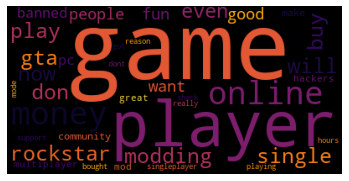

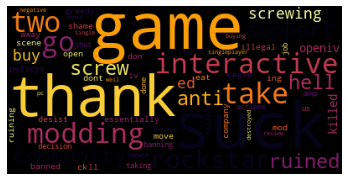

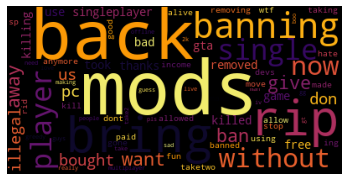

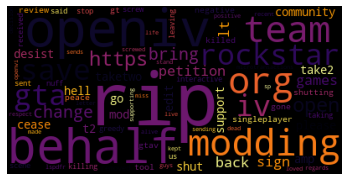

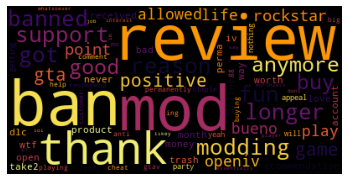

In [28]:
# Get topic contents and visualize the topics, example here - for negative reviews
tfidf_vect_feature_names = tfidf_vect.get_feature_names()
print_top_words(nmf, tfidf_vect_feature_names, 100, colormap='inferno')

In [29]:
'''
Here's another data setup for topic modeling, but for different example:
extract topics from positive reviews using LDA
'''

clean_data = data.dropna()

# Example: here we want to find out why customers who left positive reviews for certain product are satisfied, 
train = clean_data[(clean_data['title'] == 'Grand Theft Auto V') & (clean_data['recommendation_int'] == 1)]

X = train['review']
y = train['recommendation_int']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=273, stratify=y)

In [30]:
'''
This cell can be used for topic modeling w/ LDA

For the data used here NMF is often faster (so more preferable)

For unsupervised text document models, 
it is often good to remove very common words,
as they might otherwise dominate the analysis. 
We’ll remove words that appear in atleast  20  percent  of  the  documents,  
and  we’ll  limit  the  bag-of-words  model  to  the
10,000 words that are most common after removing the top 20 percent:
'''

from sklearn.decomposition import LatentDirichletAllocation

vect = CountVectorizer(max_features=10000, max_df=.20)
X_train_topical = vect.fit_transform(X_train)

lda = LatentDirichletAllocation(n_components=5, learning_method="batch",
                                max_iter=25, random_state=273)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X_train_topical)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


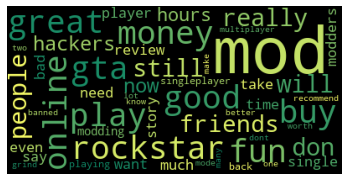

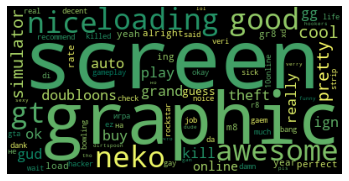

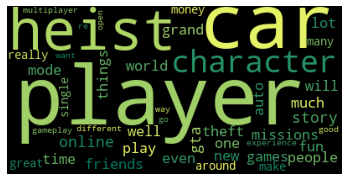

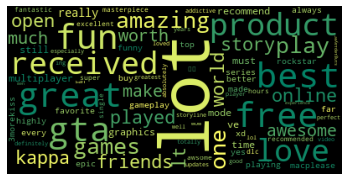

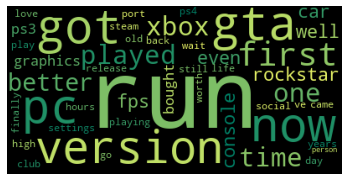

In [32]:
vect_feature_names = vect.get_feature_names()
print_top_words(lda, vect_feature_names, 100, colormap='summer')

In [33]:
'''
 This cell can be used to calculate the strength of positive/negative association 
 of the current product (e.g. 'Grand Theft Auto V') with other products
 being mentioned in the customers' reviews for this product
 
 Essentially it's an NER task with elements of Sentiment Analysis
 
 WIP, currently only shows entity counts from short handcrafted list
 across all the reviews
  
 [Assumptions: 
     Customers tend to mention other products in positive reviews for this product
     when they think this product is at least no worse than other products, 
     or maybe even better,
     when they like certain positive features from other products are found in this product
     etc.
     
     At the same time customers mention other products in negative reviews for this product
     when they think this product is at least no better than other products,
     or maybe even worse,
     when they dislike certain negative features from other products are found in this product
     etc.
     
     Ties can be broken based on majority ratio/percent difference threshold, etc.
     Cool idea for breaking ties and visualization - LogisticRegression w/ eli5 visualizer
     on both pos/neg reviews set for a preduct]
     
 WORK IN PROGRESS: 
     Requires heavy entity matching, coz no one writes 
     full correct names of the products like they are in the database;
     
     Demo example is provided for the whole set of reviews(all products mixed)
     with some custom entity matching
     
     Potentially cool implementation w/ LogisticRegression(see above)
'''

# Data preparation
clean_data = data.dropna()

# Usecase of the final version
#train = clean_data[(clean_data['title'] == 'Grand Theft Auto V') 
                  # & (clean_data['recommendation_int'] == 1)]  #< pick one
                  # & (clean_data['recommendation_int'] == 0)]  #  not both

# Demo usecase
train = clean_data

# Routine split for potential use in logistic regression
X = train['review']
y = train['recommendation_int']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=273, stratify=y)



# Kind of a comprehensive list of entities (product names from Steam store), about 40k names,
# Requires entity matching to be of practical value
#steam_games = pd.read_csv("../input/steam-games-complete-dataset/steam_games.csv")
#ents = steam_games['name'].unique()

# Demo list of entities with matching 
ents = {'GTA': 0, 'GTA5':1, 'GTAV':2, 'GTA V':3, 'GTA 5':4, 'gta 5':5, 'gta5':6, 'PUBG':7, 'pubg':8}

# Making custom vocabulary from entities to do NER via BoW
ner = CountVectorizer(vocabulary=ents)
ner_fit=ner.fit_transform(X_train)

# Sum entity mentions across the corpus
counts = np.asarray(ner_fit.sum(axis=0)).ravel()

# Output entity names and number of mentions across the corpus
for ent_idx, ent in enumerate(ents):
    
    #DEBUG
    #print(ent_idx, ent)
    
    if (counts[ent_idx] != 0):
        print(ent, counts[ent_idx])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


gta5 577
pubg 9445
